In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

In [ ]:
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/train.csv', names=['ClassNumber', 'Title', 'Description'])
test_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/test.csv', names=['ClassNumber', 'Title', 'Description'])

In [ ]:
print("Train data shape:", train_df.shape)
print("Test data shape:", test_df.shape)

Train data shape: (120000, 3)
Test data shape: (7600, 3)


In [ ]:
train_df.head()

,ClassNumber,Title,Description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."


In [ ]:
test_df.head()

,ClassNumber,Title,Description
0,3,Fears for T N pension after talks,Unions representing workers at Turner Newall...
1,4,The Race is On: Second Private Team Sets Launc...,"SPACE.com - TORONTO, Canada -- A second\team o..."
2,4,Ky. Company Wins Grant to Study Peptides (AP),AP - A company founded by a chemistry research...
3,4,Prediction Unit Helps Forecast Wildfires (AP),AP - It's barely dawn when Mike Fitzpatrick st...
4,4,Calif. Aims to Limit Farm-Related Smog (AP),AP - Southern California's smog-fighting agenc...


In [ ]:
class_distribution_train = train_df['ClassNumber'].value_counts()
class_distribution_test = test_df['ClassNumber'].value_counts()

In [ ]:
print("\nTrain class distribution:\n", class_distribution_train)
print("\nTest class distribution:\n", class_distribution_test)


Train class distribution:
 ClassNumber
3    30000
4    30000
2    30000
1    30000
Name: count, dtype: int64

Test class distribution:
 ClassNumber
3    1900
4    1900
2    1900
1    1900
Name: count, dtype: int64


In [ ]:
train_df.describe()

,ClassNumber
count,120000.000000
mean,2.500000
std,1.118039
min,1.000000
25%,1.750000
50%,2.500000
75%,3.250000
max,4.000000


In [ ]:
test_df.describe()

,ClassNumber
count,7600.000000
mean,2.500000
std,1.118108
min,1.000000
25%,1.750000
50%,2.500000
75%,3.250000
max,4.000000


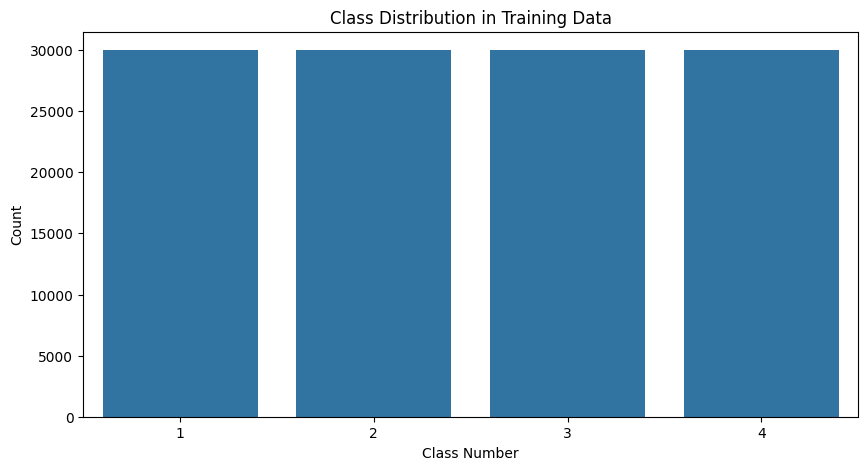

In [ ]:
plt.figure(figsize=(10, 5))
sns.countplot(x='ClassNumber', data=train_df)
plt.title('Class Distribution in Training Data')
plt.xlabel('Class Number')
plt.ylabel('Count')
plt.show()

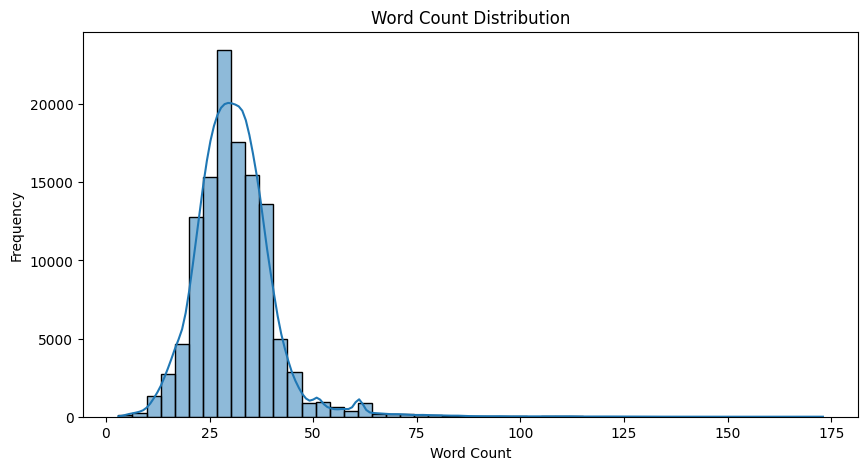

In [ ]:
word_counts = train_df['Description'].apply(lambda x: len(x.split()))
plt.figure(figsize=(10, 5))
sns.histplot(word_counts, bins=50, kde=True)
plt.title('Word Count Distribution')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()

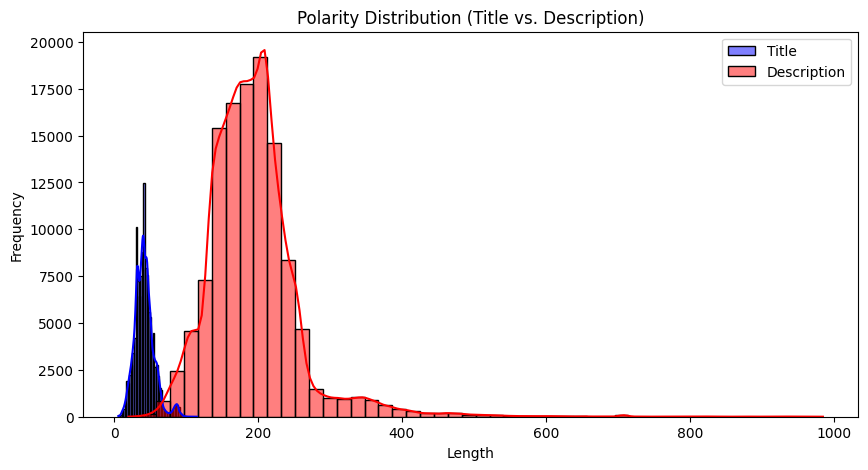

In [ ]:
polarity = train_df.apply(lambda row: (len(row['Title']), len(row['Description'])), axis=1)
title_lengths, desc_lengths = zip(*polarity)
plt.figure(figsize=(10, 5))
sns.histplot(title_lengths, bins=50, kde=True, color='blue', label='Title')
sns.histplot(desc_lengths, bins=50, kde=True, color='red', label='Description')
plt.title('Polarity Distribution (Title vs. Description)')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
def clean_text(text):
    # removing punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # converting text to lowercase
    text = text.lower()
    # removing stopwords
    stop_words = set(stopwords.words('english'))   # english stopwords
    word_tokens = word_tokenize(text)    # tokenize
    filtered_text = [word for word in word_tokens if word not in stop_words]
    # joining tokens back into a single string
    cleaned_text = ' '.join(filtered_text)
    return cleaned_text


In [ ]:
# applying clean text function to both the columns of train and test dataset
train_df['Title'] = train_df['Title'].apply(clean_text)
train_df['Description'] = train_df['Description'].apply(clean_text)
test_df['Title'] = test_df['Title'].apply(clean_text)
test_df['Description'] = test_df['Description'].apply(clean_text)

In [ ]:
# creating vocabulary from the clxtned test
vocab = set()
for text in train_df['Title']:
    vocab.update(text.split())
for text in train_df['Description']:
    vocab.update(text.split())

In [ ]:
from gensim.models import Word2Vec

In [ ]:
# training Word2Vec model on tokenized text data
train_tokens = train_df['Description'].apply(word_tokenize)

In [ ]:
word2vec_model = Word2Vec(train_tokens, vector_size=100, window=5, min_count=1, workers=4)

In [ ]:
def text_to_embeddings(text, word2vec_model):
    tokens = word_tokenize(text)
    embeddings = [word2vec_model.wv[token] for token in tokens if token in word2vec_model.wv]
    if embeddings:
        return np.mean(embeddings, axis=0)  # embeddings to get a single vector for the text
    else:
        return np.zeros(word2vec_model.vector_size)

In [ ]:
# converting text data to embeddings and add to DataFrames
train_df['Title_Embeddings'] = train_df['Title'].apply(lambda x: text_to_embeddings(x, word2vec_model))
train_df['Description_Embeddings'] = train_df['Description'].apply(lambda x: text_to_embeddings(x, word2vec_model))
test_df['Title_Embeddings'] = test_df['Title'].apply(lambda x: text_to_embeddings(x, word2vec_model))
test_df['Description_Embeddings'] = test_df['Description'].apply(lambda x: text_to_embeddings(x, word2vec_model))

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

In [ ]:
# custom daataset class for text data
class TextDataset(Dataset):
    def __init__(self, df):
        self.data = df

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Return a tuple containing the input and output for each sample
        return (self.data['Title_Embeddings'].iloc[idx],
                self.data['Description_Embeddings'].iloc[idx],
                self.data['ClassNumber'].iloc[idx])


In [ ]:
# splitting the datatset into train test and valdidation in 70:15:15
train_data, val_test_data = train_test_split(train_df, test_size=0.3, random_state=42)
val_data, test_data = train_test_split(val_test_data, test_size=0.5, random_state=42)

In [ ]:
# creating datasets and data loaders for train, validation, and test sets
train_dataset = TextDataset(train_data)
val_dataset = TextDataset(val_data)
test_dataset = TextDataset(test_data)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

In [ ]:
class TransformerModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(TransformerModel, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_classes = num_classes

        # defining the encoder layers
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=input_size, nhead=10)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=6)

        # defining output layer
        self.fc = nn.Linear(input_size * 2, num_classes)  # updating input size to input_size * 2

    def forward(self, title_embed, desc_embed):
        # pass the embeddings through the Transformer encoder
        title_output = self.transformer_encoder(title_embed)
        desc_output = self.transformer_encoder(desc_embed)

        # Concatenating the outputs
        combined_output = torch.cat((title_output, desc_output), dim=1)

        # passing through output layer
        output = self.fc(combined_output)
        return output


In [ ]:
model = TransformerModel(input_size=100, hidden_size=128, num_classes=4) #initializing model

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to the specified device
model.to(device)

TransformerModel(
  (encoder_layer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=100, out_features=100, bias=True)
    )
    (linear1): Linear(in_features=100, out_features=2048, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=2048, out_features=100, bias=True)
    (norm1): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-5): 6 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=100, out_features=100, bias=True)
        )
        (linear1): Linear(in_features=100, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)


In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_curve, roc_auc_score, confusion_matrix

In [ ]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(5):
    model.train()  # Set model to training mode
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    for title_embed, desc_embed, labels in train_loader:
        # converting input data to the same data type as model parameters
        title_embed = title_embed.to(device=device, dtype=torch.float)
        desc_embed = desc_embed.to(device=device, dtype=torch.float)
        labels -= 1
        labels = labels.to(device=device)

        # zero the gradients
        optimizer.zero_grad()

        # forward pass
        outputs = model(title_embed, desc_embed)

        # calculate loss
        loss = criterion(outputs, labels)

        # backward pass and optimization
        loss.backward()
        optimizer.step()

        # appending training loss
        train_loss += loss.item() * title_embed.size(0)

        # appending coorect predicted training values
        _, predicted_train = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted_train == labels).sum().item()

    # calculating average training loss for the epoch
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    # calculating training accuracy for the epoch
    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)

    # Validation
    model.eval()  # set model to eval mode
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for title_embed, desc_embed, labels in val_loader:
            # converting input data to the same data type as model parameters
            title_embed = title_embed.to(device=device, dtype=torch.float)
            desc_embed = desc_embed.to(device=device, dtype=torch.float)
            labels -= 1
            labels = labels.to(device=device)

            # Forward pass
            outputs = model(title_embed, desc_embed)

            # calculating loss
            loss = criterion(outputs, labels)

            # appending validation loss
            val_loss += loss.item() * title_embed.size(0)

            # appending coorect predicted validation values
            _, predicted_val = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted_val == labels).sum().item()

    # calculating average validation loss for the epoch
    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)

    # calculating validation accuracy for the epoch
    val_accuracy = correct_val / total_val
    val_accuracies.append(val_accuracy)

    print(f'Epoch [{epoch+1}/{5}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}')

Epoch [1/5], Train Loss: 0.3748, Val Loss: 0.3416, Train Acc: 0.8707, Val Acc: 0.8819
Epoch [2/5], Train Loss: 0.3297, Val Loss: 0.3141, Train Acc: 0.8856, Val Acc: 0.8897
Epoch [3/5], Train Loss: 0.3122, Val Loss: 0.3090, Train Acc: 0.8903, Val Acc: 0.8904
Epoch [4/5], Train Loss: 0.2963, Val Loss: 0.3001, Train Acc: 0.8951, Val Acc: 0.8930
Epoch [5/5], Train Loss: 0.2825, Val Loss: 0.3016, Train Acc: 0.8999, Val Acc: 0.8927


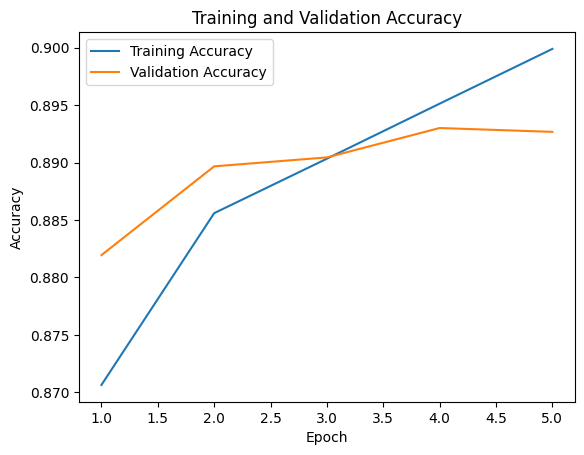

In [ ]:
# Plot training and validation accuracy over epochs
plt.plot(range(1, 6), train_accuracies, label='Training Accuracy')
plt.plot(range(1, 6), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

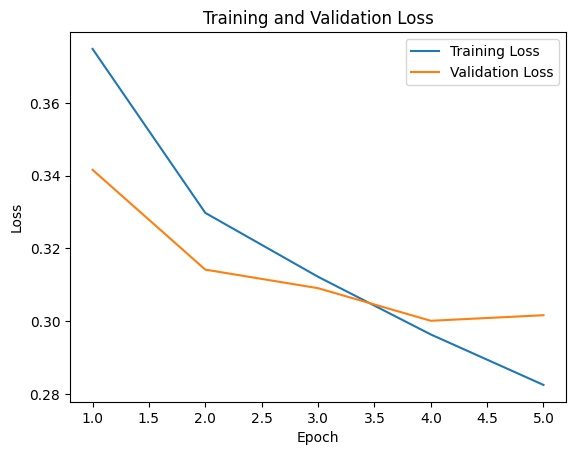

In [ ]:
# Plot training and validation loss over epochs
plt.plot(range(1, 6), train_losses, label='Training Loss')
plt.plot(range(1, 6), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [ ]:
# Testing
model.eval()  # set model to evaluation mode
test_loss = 0.0
correct_test = 0
total_test = 0
predicted_labels = []
true_labels = []

with torch.no_grad():
    for title_embed, desc_embed, labels in test_loader:
        # converting input data to the same data type as model parameters
        title_embed = title_embed.to(device=device, dtype=torch.float)
        desc_embed = desc_embed.to(device=device, dtype=torch.float)
        labels -= 1
        labels = labels.to(device=device)

        # Forward pass
        outputs = model(title_embed, desc_embed)

        # calculating loss
        loss = criterion(outputs, labels)
        test_loss += loss.item() * title_embed.size(0)

        # tracking true and predicted labels
        _, predicted = torch.max(outputs, 1)
        predicted_labels.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

        # calculating test accuracy
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

# calculating average test loss
test_loss /= len(test_loader.dataset)

# calculating test accuracy
test_accuracy = correct_test / total_test
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

Test Loss: 0.3009, Test Accuracy: 0.8950


In [ ]:
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print('Confusion Matrix:')
print(conf_matrix)

Confusion Matrix:
[[3909  138  237  165]
 [  54 4414   57   75]
 [ 118   26 3891  453]
 [ 126   31  410 3896]]


In [ ]:
precision, recall, f1_score, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='weighted')
print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1_score:.4f}')

Precision: 0.8960, Recall: 0.8950, F1 Score: 0.8953


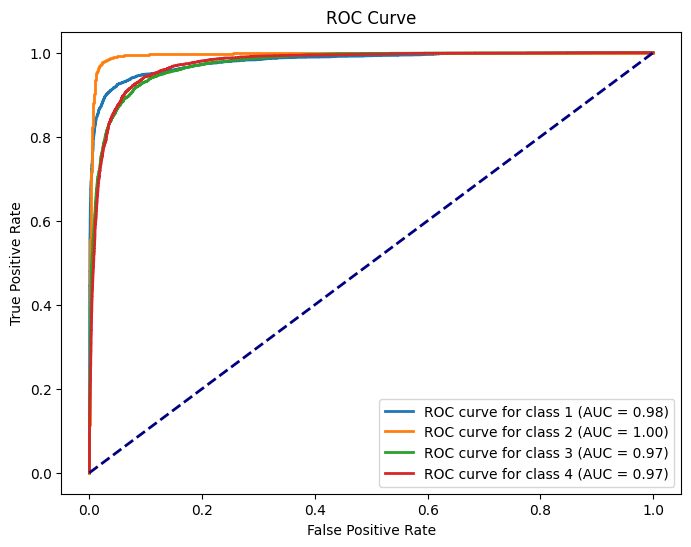

In [ ]:
from sklearn.metrics import roc_curve, auc

# Initialize lists to store true labels and predicted probabilities
true_labels = []
predicted_probs = []

# Set the model to evaluation mode
model.eval()

with torch.no_grad():
    for title_embed, desc_embed, labels in test_loader:
        # Convert input data to the same data type as model parameters
        title_embed = title_embed.to(device=device, dtype=torch.float)
        desc_embed = desc_embed.to(device=device, dtype=torch.float)
        labels -= 1
        labels = labels.to(device=device)

        # Forward pass
        outputs = model(title_embed, desc_embed)

        # Apply softmax to get probabilities
        probs = torch.nn.functional.softmax(outputs, dim=1)

        # Append true labels and predicted probabilities
        true_labels.extend(labels.cpu().numpy())
        predicted_probs.extend(probs.cpu().numpy())

# Convert lists to numpy arrays
true_labels = np.array(true_labels)
predicted_probs = np.array(predicted_probs)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(true_labels == i, predicted_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(8, 6))
for i in range(4):
    plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve for class %d (AUC = %0.2f)' % (i + 1, roc_auc[i]))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [ ]:
model_path = '/content/sample_data/model_weights_base.pth'

# Save the model weights
torch.save(model.state_dict(), model_path)

print(f"Model weights saved to {model_path}")


Model weights saved to /content/sample_data/model_weights_base.pth


## Model 1

l2 regularization

In [ ]:
model = TransformerModel(input_size=100, hidden_size=128, num_classes=4)
model.to(device)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


TransformerModel(
  (encoder_layer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=100, out_features=100, bias=True)
    )
    (linear1): Linear(in_features=100, out_features=2048, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=2048, out_features=100, bias=True)
    (norm1): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-5): 6 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=100, out_features=100, bias=True)
        )
        (linear1): Linear(in_features=100, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)

In [ ]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(5):
    model.train()  # Set model to training mode
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    for title_embed, desc_embed, labels in train_loader:
        # converting input data to the same data type as model parameters
        title_embed = title_embed.to(device=device, dtype=torch.float)
        desc_embed = desc_embed.to(device=device, dtype=torch.float)
        labels -= 1
        labels = labels.to(device=device)

        # zero the gradients
        optimizer.zero_grad()

        # forward pass
        outputs = model(title_embed, desc_embed)

        # calculate loss
        loss = criterion(outputs, labels)

        # backward pass and optimization
        loss.backward()
        optimizer.step()

        # appending training loss
        train_loss += loss.item() * title_embed.size(0)

        # appending coorect predicted training values
        _, predicted_train = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted_train == labels).sum().item()

    # calculating average training loss for the epoch
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    # calculating training accuracy for the epoch
    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)

    # Validation
    model.eval()  # set model to eval mode
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for title_embed, desc_embed, labels in val_loader:
            # converting input data to the same data type as model parameters
            title_embed = title_embed.to(device=device, dtype=torch.float)
            desc_embed = desc_embed.to(device=device, dtype=torch.float)
            labels -= 1
            labels = labels.to(device=device)

            # Forward pass
            outputs = model(title_embed, desc_embed)

            # calculating loss
            loss = criterion(outputs, labels)

            # appending validation loss
            val_loss += loss.item() * title_embed.size(0)

            # appending coorect predicted validation values
            _, predicted_val = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted_val == labels).sum().item()

    # calculating average validation loss for the epoch
    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)

    # calculating validation accuracy for the epoch
    val_accuracy = correct_val / total_val
    val_accuracies.append(val_accuracy)

    print(f'Epoch [{epoch+1}/{5}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}')

Epoch [1/5], Train Loss: 0.3735, Val Loss: 0.3566, Train Acc: 0.8712, Val Acc: 0.8751
Epoch [2/5], Train Loss: 0.3308, Val Loss: 0.3208, Train Acc: 0.8847, Val Acc: 0.8878
Epoch [3/5], Train Loss: 0.3122, Val Loss: 0.3139, Train Acc: 0.8914, Val Acc: 0.8899
Epoch [4/5], Train Loss: 0.2974, Val Loss: 0.3062, Train Acc: 0.8951, Val Acc: 0.8918
Epoch [5/5], Train Loss: 0.2844, Val Loss: 0.3051, Train Acc: 0.8999, Val Acc: 0.8931


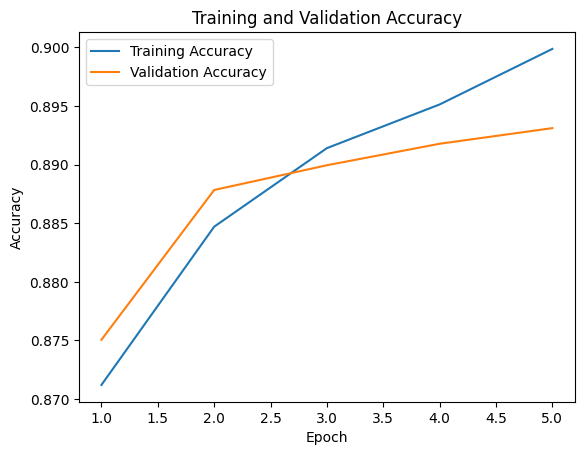

In [ ]:
# Plot training and validation accuracy over epochs
plt.plot(range(1, 6), train_accuracies, label='Training Accuracy')
plt.plot(range(1, 6), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

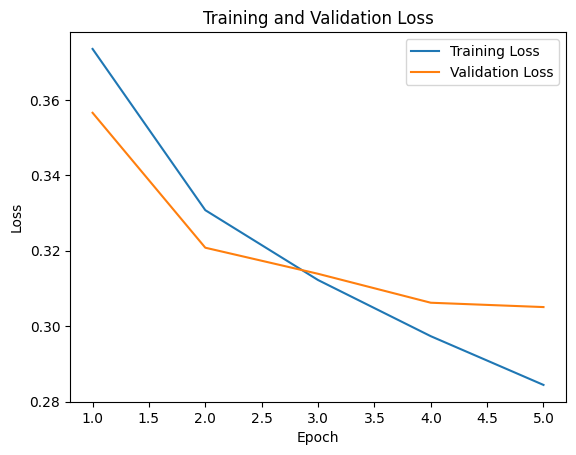

In [ ]:
# Plot training and validation loss over epochs
plt.plot(range(1, 6), train_losses, label='Training Loss')
plt.plot(range(1, 6), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [ ]:
# Testing
model.eval()  # set model to evaluation mode
test_loss = 0.0
correct_test = 0
total_test = 0
predicted_labels = []
true_labels = []

with torch.no_grad():
    for title_embed, desc_embed, labels in test_loader:
        # converting input data to the same data type as model parameters
        title_embed = title_embed.to(device=device, dtype=torch.float)
        desc_embed = desc_embed.to(device=device, dtype=torch.float)
        labels -= 1
        labels = labels.to(device=device)

        # Forward pass
        outputs = model(title_embed, desc_embed)

        # calculating loss
        loss = criterion(outputs, labels)
        test_loss += loss.item() * title_embed.size(0)

        # tracking true and predicted labels
        _, predicted = torch.max(outputs, 1)
        predicted_labels.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

        # calculating test accuracy
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

# calculating average test loss
test_loss /= len(test_loader.dataset)

# calculating test accuracy
test_accuracy = correct_test / total_test
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

Test Loss: 0.3036, Test Accuracy: 0.8931


In [ ]:
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print('Confusion Matrix:')
print(conf_matrix)

Confusion Matrix:
[[3919  162  217  151]
 [  50 4476   26   48]
 [ 120   69 3828  471]
 [ 147   70  393 3853]]


In [ ]:
precision, recall, f1_score, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='weighted')
print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1_score:.4f}')

Precision: 0.8931, Recall: 0.8931, F1 Score: 0.8929


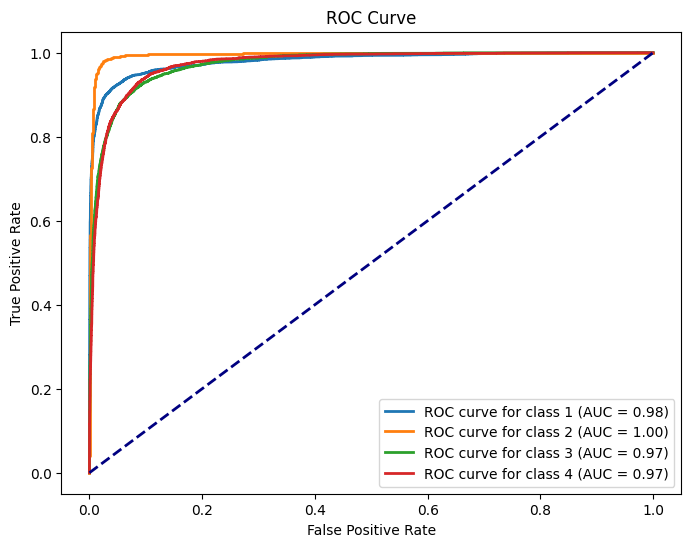

In [ ]:
from sklearn.metrics import roc_curve, auc

# Initialize lists to store true labels and predicted probabilities
true_labels = []
predicted_probs = []

# Set the model to evaluation mode
model.eval()

with torch.no_grad():
    for title_embed, desc_embed, labels in test_loader:
        # Convert input data to the same data type as model parameters
        title_embed = title_embed.to(device=device, dtype=torch.float)
        desc_embed = desc_embed.to(device=device, dtype=torch.float)
        labels -= 1
        labels = labels.to(device=device)

        # Forward pass
        outputs = model(title_embed, desc_embed)

        # Apply softmax to get probabilities
        probs = torch.nn.functional.softmax(outputs, dim=1)

        # Append true labels and predicted probabilities
        true_labels.extend(labels.cpu().numpy())
        predicted_probs.extend(probs.cpu().numpy())

# Convert lists to numpy arrays
true_labels = np.array(true_labels)
predicted_probs = np.array(predicted_probs)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(true_labels == i, predicted_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(8, 6))
for i in range(4):
    plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve for class %d (AUC = %0.2f)' % (i + 1, roc_auc[i]))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [ ]:
model_path = '/content/sample_data/model_weights_l2.pth'

# Save the model weights
torch.save(model.state_dict(), model_path)

print(f"Model weights saved to {model_path}")

Model weights saved to /content/sample_data/model_weights_l2.pth


## Model 2

Learning rate tuning - lr = 0.001

In [ ]:
model = TransformerModel(input_size=100, hidden_size=128, num_classes=4)
model.to(device)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


TransformerModel(
  (encoder_layer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=100, out_features=100, bias=True)
    )
    (linear1): Linear(in_features=100, out_features=2048, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=2048, out_features=100, bias=True)
    (norm1): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-5): 6 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=100, out_features=100, bias=True)
        )
        (linear1): Linear(in_features=100, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

In [ ]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(5):
    model.train()  # Set model to training mode
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    for title_embed, desc_embed, labels in train_loader:
        # converting input data to the same data type as model parameters
        title_embed = title_embed.to(device=device, dtype=torch.float)
        desc_embed = desc_embed.to(device=device, dtype=torch.float)
        labels -= 1
        labels = labels.to(device=device)

        # zero the gradients
        optimizer.zero_grad()

        # forward pass
        outputs = model(title_embed, desc_embed)

        # calculate loss
        loss = criterion(outputs, labels)

        # backward pass and optimization
        loss.backward()
        optimizer.step()

        # appending training loss
        train_loss += loss.item() * title_embed.size(0)

        # appending coorect predicted training values
        _, predicted_train = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted_train == labels).sum().item()

    # calculating average training loss for the epoch
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    # calculating training accuracy for the epoch
    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)

    # Validation
    model.eval()  # set model to eval mode
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for title_embed, desc_embed, labels in val_loader:
            # converting input data to the same data type as model parameters
            title_embed = title_embed.to(device=device, dtype=torch.float)
            desc_embed = desc_embed.to(device=device, dtype=torch.float)
            labels -= 1
            labels = labels.to(device=device)

            # Forward pass
            outputs = model(title_embed, desc_embed)

            # calculating loss
            loss = criterion(outputs, labels)

            # appending validation loss
            val_loss += loss.item() * title_embed.size(0)

            # appending coorect predicted validation values
            _, predicted_val = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted_val == labels).sum().item()

    # calculating average validation loss for the epoch
    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)

    # calculating validation accuracy for the epoch
    val_accuracy = correct_val / total_val
    val_accuracies.append(val_accuracy)

    print(f'Epoch [{epoch+1}/{5}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}')

Epoch [1/5], Train Loss: 0.4885, Val Loss: 0.4324, Train Acc: 0.8445, Val Acc: 0.8694
Epoch [2/5], Train Loss: 0.4246, Val Loss: 0.4650, Train Acc: 0.8632, Val Acc: 0.8504
Epoch [3/5], Train Loss: 0.4055, Val Loss: 0.3859, Train Acc: 0.8668, Val Acc: 0.8733
Epoch [4/5], Train Loss: 0.3840, Val Loss: 0.3783, Train Acc: 0.8733, Val Acc: 0.8781
Epoch [5/5], Train Loss: 0.3703, Val Loss: 0.3636, Train Acc: 0.8769, Val Acc: 0.8773


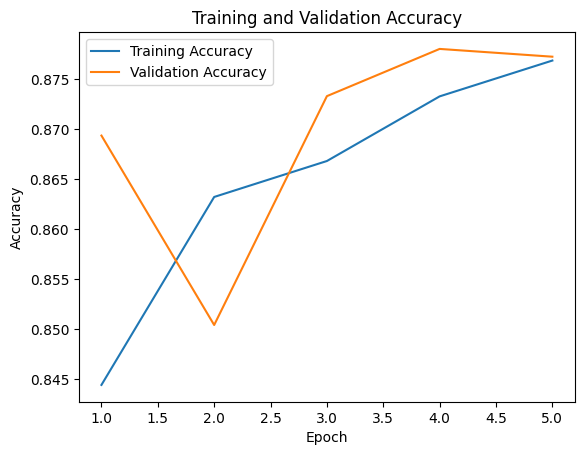

In [ ]:
# Plot training and validation accuracy over epochs
plt.plot(range(1, 6), train_accuracies, label='Training Accuracy')
plt.plot(range(1, 6), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

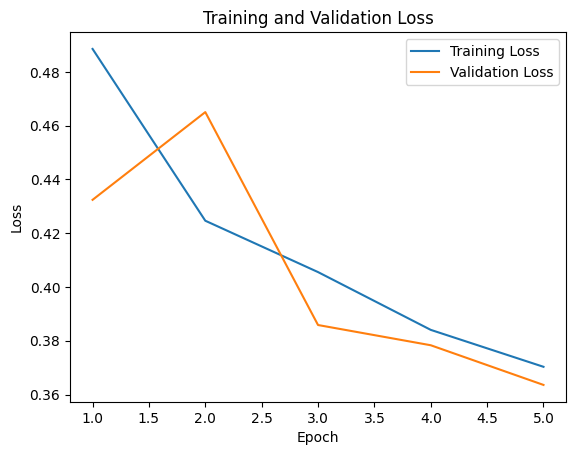

In [ ]:
# Plot training and validation loss over epochs
plt.plot(range(1, 6), train_losses, label='Training Loss')
plt.plot(range(1, 6), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [ ]:
# Testing
model.eval()  # set model to evaluation mode
test_loss = 0.0
correct_test = 0
total_test = 0
predicted_labels = []
true_labels = []

with torch.no_grad():
    for title_embed, desc_embed, labels in test_loader:
        # converting input data to the same data type as model parameters
        title_embed = title_embed.to(device=device, dtype=torch.float)
        desc_embed = desc_embed.to(device=device, dtype=torch.float)
        labels -= 1
        labels = labels.to(device=device)

        # Forward pass
        outputs = model(title_embed, desc_embed)

        # calculating loss
        loss = criterion(outputs, labels)
        test_loss += loss.item() * title_embed.size(0)

        # tracking true and predicted labels
        _, predicted = torch.max(outputs, 1)
        predicted_labels.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

        # calculating test accuracy
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

# calculating average test loss
test_loss /= len(test_loader.dataset)

# calculating test accuracy
test_accuracy = correct_test / total_test
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

Test Loss: 0.3588, Test Accuracy: 0.8776


In [ ]:
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print('Confusion Matrix:')
print(conf_matrix)

Confusion Matrix:
[[3872  173  253  151]
 [  66 4436   38   60]
 [ 126   47 3481  834]
 [ 162   76  217 4008]]


In [ ]:
precision, recall, f1_score, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='weighted')
print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1_score:.4f}')

Precision: 0.8803, Recall: 0.8776, F1 Score: 0.8772


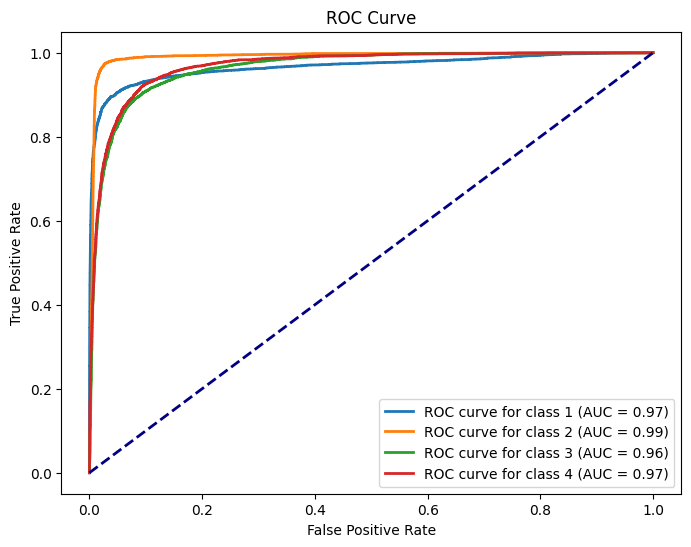

In [ ]:
from sklearn.metrics import roc_curve, auc

# Initialize lists to store true labels and predicted probabilities
true_labels = []
predicted_probs = []

# Set the model to evaluation mode
model.eval()

with torch.no_grad():
    for title_embed, desc_embed, labels in test_loader:
        # Convert input data to the same data type as model parameters
        title_embed = title_embed.to(device=device, dtype=torch.float)
        desc_embed = desc_embed.to(device=device, dtype=torch.float)
        labels -= 1
        labels = labels.to(device=device)

        # Forward pass
        outputs = model(title_embed, desc_embed)

        # Apply softmax to get probabilities
        probs = torch.nn.functional.softmax(outputs, dim=1)

        # Append true labels and predicted probabilities
        true_labels.extend(labels.cpu().numpy())
        predicted_probs.extend(probs.cpu().numpy())

# Convert lists to numpy arrays
true_labels = np.array(true_labels)
predicted_probs = np.array(predicted_probs)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(true_labels == i, predicted_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(8, 6))
for i in range(4):
    plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve for class %d (AUC = %0.2f)' % (i + 1, roc_auc[i]))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [ ]:
model_path = '/content/sample_data/model_weights_LR.pth'

# Save the model weights
torch.save(model.state_dict(), model_path)

print(f"Model weights saved to {model_path}")

Model weights saved to /content/sample_data/model_weights_LR.pth


## Model 3

Early Stopping

In [ ]:
model = TransformerModel(input_size=100, hidden_size=128, num_classes=4)
model.to(device)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


TransformerModel(
  (encoder_layer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=100, out_features=100, bias=True)
    )
    (linear1): Linear(in_features=100, out_features=2048, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=2048, out_features=100, bias=True)
    (norm1): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-5): 6 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=100, out_features=100, bias=True)
        )
        (linear1): Linear(in_features=100, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)

In [ ]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

best_val_loss = float('inf')
best_epoch = 0
patience = 2  # number of epochs to wait for improvement

for epoch in range(20):
    model.train()  # set model to training mode
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    for title_embed, desc_embed, labels in train_loader:
        # converting input data to the same data type as model parameters
        title_embed = title_embed.to(device=device, dtype=torch.float)
        desc_embed = desc_embed.to(device=device, dtype=torch.float)
        labels -= 1
        labels = labels.to(device=device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(title_embed, desc_embed)

        # calculating loss
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # appending training loss
        train_loss += loss.item() * title_embed.size(0)

        # appending coorect predicted validation values
        _, predicted_train = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted_train == labels).sum().item()

    # calculating average training loss for the epoch
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    # calculating training accuracy for the epoch
    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)

    # Validation
    model.eval()  # set model to evaluation mode
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for title_embed, desc_embed, labels in val_loader:
            # converting input data to the same data type as model parameters
            title_embed = title_embed.to(device=device, dtype=torch.float)
            desc_embed = desc_embed.to(device=device, dtype=torch.float)
            labels -= 1
            labels = labels.to(device=device)

            # Forward pass
            outputs = model(title_embed, desc_embed)

            # calculating loss
            loss = criterion(outputs, labels)

            # appending validation loss
            val_loss += loss.item() * title_embed.size(0)

            # tracking validation accuracy
            _, predicted_val = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted_val == labels).sum().item()

    # calculating average validation loss for the epoch
    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)

    # calculating validation accuracy for the epoch
    val_accuracy = correct_val / total_val
    val_accuracies.append(val_accuracy)

    print(f'Epoch [{epoch+1}/{20}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}')

    # check for improvement in validation loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_epoch = epoch
    else:
        # ifIf no improvement, decrement patience
        patience -= 1
        if patience == 0:
            print("Early stopping!")
            break

print(f"Best epoch: {best_epoch+1}, Best validation loss: {best_val_loss:.4f}")


Epoch [1/20], Train Loss: 0.3778, Val Loss: 0.3438, Train Acc: 0.8686, Val Acc: 0.8831
Epoch [2/20], Train Loss: 0.3312, Val Loss: 0.3255, Train Acc: 0.8841, Val Acc: 0.8878
Epoch [3/20], Train Loss: 0.3122, Val Loss: 0.3157, Train Acc: 0.8910, Val Acc: 0.8898
Epoch [4/20], Train Loss: 0.2969, Val Loss: 0.3004, Train Acc: 0.8964, Val Acc: 0.8949
Epoch [5/20], Train Loss: 0.2841, Val Loss: 0.3032, Train Acc: 0.9001, Val Acc: 0.8943
Epoch [6/20], Train Loss: 0.2707, Val Loss: 0.2974, Train Acc: 0.9041, Val Acc: 0.8941
Epoch [7/20], Train Loss: 0.2597, Val Loss: 0.2983, Train Acc: 0.9086, Val Acc: 0.8972
Early stopping!
Best epoch: 6, Best validation loss: 0.2974


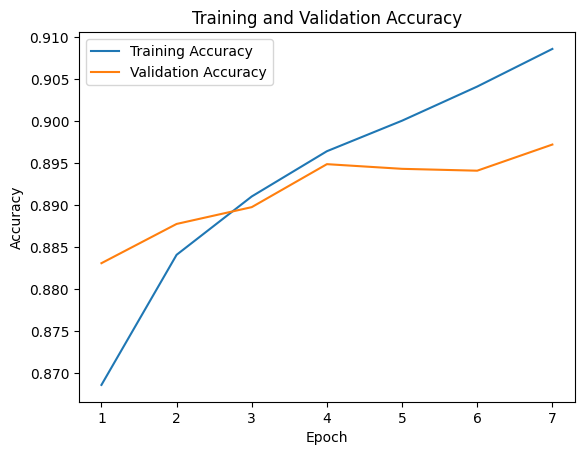

In [ ]:
# Plot training and validation accuracy over epochs
plt.plot(range(1, 8), train_accuracies, label='Training Accuracy')   # manually changed the range
plt.plot(range(1, 8), val_accuracies, label='Validation Accuracy')   # according to number of epochs
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

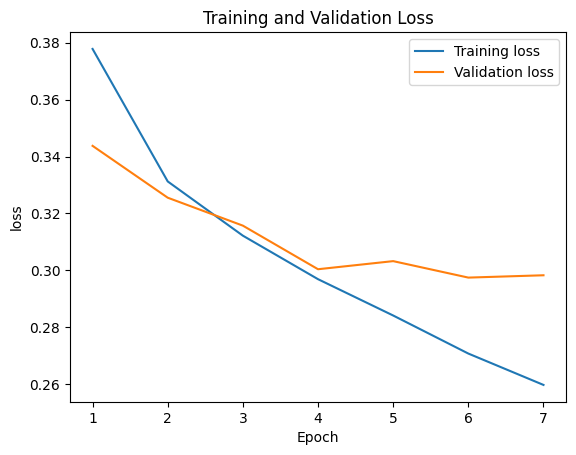

In [ ]:
# Plot training and validation accuracy over epochs
plt.plot(range(1, 8), train_losses, label='Training loss')   # manually changed the range
plt.plot(range(1, 8), val_losses, label='Validation loss')   # according to number of epochs
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [ ]:
# Testing
model.eval()  # Set the model to evaluation mode
test_loss = 0.0
correct_test = 0
total_test = 0
predicted_labels = []
true_labels = []

with torch.no_grad():
    for title_embed, desc_embed, labels in test_loader:
        # Convert input data to the same data type as model parameters
        title_embed = title_embed.to(device=device, dtype=torch.float)
        desc_embed = desc_embed.to(device=device, dtype=torch.float)
        labels -= 1
        labels = labels.to(device=device)

        # Forward pass
        outputs = model(title_embed, desc_embed)

        # calculating loss
        loss = criterion(outputs, labels)
        test_loss += loss.item() * title_embed.size(0)

        # tracking true and predicted labels
        _, predicted = torch.max(outputs, 1)
        predicted_labels.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

        # tracking test accuracy
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

# calculating average test loss
test_loss /= len(test_loader.dataset)

# calculating test accuracy
test_accuracy = correct_test / total_test
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

Test Loss: 0.3002, Test Accuracy: 0.8983


In [ ]:
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print('Confusion Matrix:')
print(conf_matrix)

Confusion Matrix:
[[3923  158  199  169]
 [  37 4483   32   48]
 [ 125   52 3819  492]
 [ 129   59  330 3945]]


In [ ]:
precision, recall, f1_score, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='weighted')
print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1_score:.4f}')

Precision: 0.8988, Recall: 0.8983, F1 Score: 0.8982


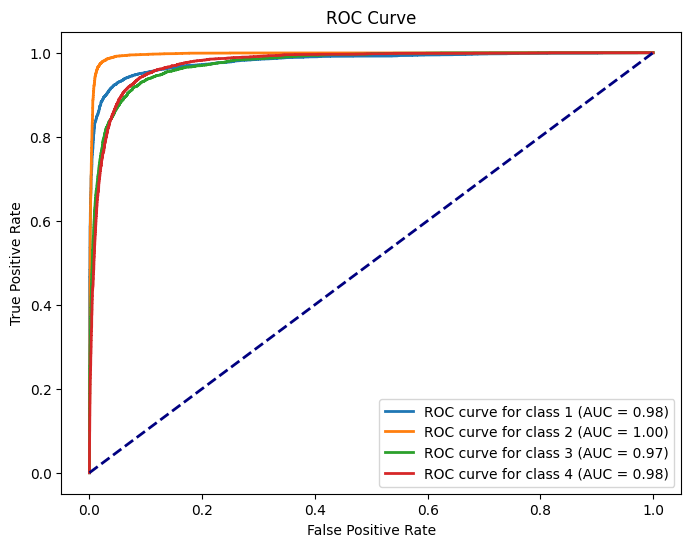

In [ ]:
from sklearn.metrics import roc_curve, auc

# Initialize lists to store true labels and predicted probabilities
true_labels = []
predicted_probs = []

# Set the model to evaluation mode
model.eval()

with torch.no_grad():
    for title_embed, desc_embed, labels in test_loader:
        # Convert input data to the same data type as model parameters
        title_embed = title_embed.to(device=device, dtype=torch.float)
        desc_embed = desc_embed.to(device=device, dtype=torch.float)
        labels -= 1
        labels = labels.to(device=device)

        # Forward pass
        outputs = model(title_embed, desc_embed)

        # Apply softmax to get probabilities
        probs = torch.nn.functional.softmax(outputs, dim=1)

        # Append true labels and predicted probabilities
        true_labels.extend(labels.cpu().numpy())
        predicted_probs.extend(probs.cpu().numpy())

# Convert lists to numpy arrays
true_labels = np.array(true_labels)
predicted_probs = np.array(predicted_probs)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(true_labels == i, predicted_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(8, 6))
for i in range(4):
    plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve for class %d (AUC = %0.2f)' % (i + 1, roc_auc[i]))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [ ]:
model_path = '/content/sample_data/model_weights_earlyS.pth'

# Save the model weights
torch.save(model.state_dict(), model_path)

print(f"Model weights saved to {model_path}")

Model weights saved to /content/sample_data/model_weights_earlyS.pth
